<a href="https://colab.research.google.com/github/Cdhernadnezr/solar-anomaly-detector/blob/main/solar-anomaly-detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SISTEMA DE DETECCIÓN DE ANOMALÍAS EN PANELES SOLARES FOTOVOLTAICOS USANDO ANÁLISIS DE IMÁGENES INFRARROJAS Y DEEP LEARNING

Este notebook implementa un sistema de clasificación binaria para detectar paneles solares defectuosos frente a paneles normales, utilizando redes neuronales convolucionales (CNN) y análisis de imágenes termográficas mediante técnicas de Deep Learning.

**Autor:** Cristopher Hernández Romanos  
**Fecha:** 2025  
**Descripción:** Implementación de clasificadores basados en CNN para identificar defectos en paneles solares a partir de imágenes térmicas.


##Librerías

In [35]:
import os
import zipfile
import cv2
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

##CONFIGURACIÓN Y UTILIDADES

In [36]:
class Config:
    """Configuración centralizada del proyecto"""
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    MAX_EPOCHS = 2
    PATIENCE = 5
    RANDOM_SEED = 42

    # Proporciones de división del dataset
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.20
    TEST_RATIO = 0.10

class Logger:
    """Sistema de logging personalizado para el proyecto"""
    STYLES = {
        'header': '\033[95m\033[1m',
        'info': '\033[94m',
        'success': '\033[92m',
        'warning': '\033[93m',
        'error': '\033[91m',
        'bold': '\033[1m',
        'end': '\033[0m'
    }

    @classmethod
    def log(cls, message, style='info'):
        print(f"{cls.STYLES[style]}{message}{cls.STYLES['end']}")

    @classmethod
    def section(cls, title):
        print(f"\n{cls.STYLES['header']}{'='*80}")
        print(f"{title}")
        print(f"{'='*80}{cls.STYLES['end']}")


##DESCARGA Y PREPARACIÓN DE DATOS

In [37]:
def download_and_extract_dataset():
    """Descarga y extrae el dataset de paneles solares infrarrojos"""
    url = "https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip"

    Logger.log("📥 Descargando dataset...", 'info')
    os.system(f"wget {url} -O solar_dataset.zip")

    Logger.log("📂 Extrayendo archivos...", 'info')
    with zipfile.ZipFile("solar_dataset.zip", 'r') as zip_ref:
        zip_ref.extractall("dataset")

    return "dataset/InfraredSolarModules"


##CLASE PARA MANEJO DE DATOS

In [38]:
class SolarDataManager:
    """Gestor de datos para el dataset de paneles solares"""

    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.df = None
        self.load_metadata()

    def load_metadata(self):
        """Carga y procesa los metadatos del dataset"""
        metadata_path = os.path.join(self.dataset_path, 'module_metadata.json')
        self.df = pd.read_json(metadata_path, orient='index').sort_index()

        # Construir rutas completas
        self.df['full_path'] = self.df['image_filepath'].apply(
            lambda x: os.path.join(self.dataset_path, x)
        )

        # Crear etiquetas binarias
        self.df['defect_status'] = self.df['anomaly_class'].apply(
            lambda x: 'Defective' if x != 'No-Anomaly' else 'Normal'
        )

        Logger.log(f"Dataset cargado: {len(self.df)} imágenes", 'success')
        self.show_distribution()

    def show_distribution(self):
        """Muestra la distribución de clases en el dataset"""
        Logger.log("📊 Distribución de clases:", 'info')
        distribution = self.df['defect_status'].value_counts()
        for status, count in distribution.items():
            percentage = (count / len(self.df)) * 100
            print(f"  • {status}: {count} ({percentage:.1f}%)")

    def create_stratified_split(self):
        """Crea división estratificada del dataset"""
        # Primera división: train+val vs test
        train_val_df, test_df = train_test_split(
            self.df,
            test_size=Config.TEST_RATIO,
            stratify=self.df['defect_status'],
            random_state=Config.RANDOM_SEED
        )

        # Segunda división: train vs val
        val_size_adjusted = Config.VAL_RATIO / (Config.TRAIN_RATIO + Config.VAL_RATIO)
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_size_adjusted,
            stratify=train_val_df['defect_status'],
            random_state=Config.RANDOM_SEED
        )

        Logger.log(f"División completada - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}", 'success')
        return train_df, val_df, test_df


##DATASET PERSONALIZADO PARA PYTORCH

In [39]:
class ThermalImageDataset(Dataset):
    """Dataset personalizado para imágenes termográficas de paneles solares"""

    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_encoder = {'Normal': 0, 'Defective': 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Cargar imagen
        img_path = self.df.iloc[idx]['full_path']
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")

        # Convertir a PIL para transformaciones
        image = Image.fromarray(image)

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        # Obtener etiqueta
        label = self.label_encoder[self.df.iloc[idx]['defect_status']]

        return image, label


##TRANSFORMACIONES DE DATOS

In [40]:
class DataTransforms:
    """Transformaciones de datos para entrenamiento y validación"""

    @staticmethod
    def get_train_transforms():
        return transforms.Compose([
            transforms.Resize((48, 32)),  # Redimensionar para mejor procesamiento
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    @staticmethod
    def get_val_transforms():
        return transforms.Compose([
            transforms.Resize((48, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])


##ARQUITECTURAS DE REDES NEURONALES

In [41]:
class CompactCNN(nn.Module):
    """Red neuronal compacta para clasificación de imágenes termográficas"""

    def __init__(self, num_classes=2):
        super(CompactCNN, self).__init__()

        # Extractor de características
        self.feature_extractor = nn.Sequential(
            # Bloque 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Bloque 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Bloque 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        # Clasificador
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

class ModifiedResNet(nn.Module):
    """ResNet modificado para imágenes termográficas pequeñas"""

    def __init__(self, num_classes=2):
        super(ModifiedResNet, self).__init__()

        # Usar ResNet18 como base
        self.backbone = models.resnet18(weights=None)

        # Modificar primera capa para 1 canal
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modificar clasificador final
        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

class ThermalNet(nn.Module):
    """Red especializada para análisis de imágenes termográficas"""

    def __init__(self, num_classes=2):
        super(ThermalNet, self).__init__()

        # Capas convolucionales con atención espacial
        self.conv_layers = nn.Sequential(
            # Primera etapa
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Segunda etapa
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Tercera etapa
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Mecanismo de atención simple
        self.attention = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Clasificador
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Extracción de características
        features = self.conv_layers(x)

        # Aplicar atención
        attention_weights = self.attention(features)
        attended_features = features * attention_weights

        # Clasificación
        output = self.classifier(attended_features)
        return output


##ENTRENADOR DE MODELOS

In [55]:
def plot_model_history(model_name, train_history, val_history):

    train_color = '#1f77b4'
    val_color = '#ff7f0e'
    epochs = range(1, len(train_history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(f"Historial de entrenamiento - {model_name}", fontsize=16, fontweight='bold')

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_history['accuracy'], linestyle='--', color=train_color, label='Entrenamiento')
    plt.plot(epochs, val_history['accuracy'], linestyle='-', color=val_color, label='Validación')
    plt.xlabel('Épocas', fontsize=12, fontweight='bold')
    plt.ylabel('Precisión (%)', fontsize=12, fontweight='bold')
    plt.title('Evolución de precisión', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_history['loss'], linestyle='--', color=train_color, label='Entrenamiento')
    plt.plot(epochs, val_history['loss'], linestyle='-', color=val_color, label='Validación')
    plt.xlabel('Épocas', fontsize=12, fontweight='bold')
    plt.ylabel('Pérdida', fontsize=12, fontweight='bold')
    plt.title('Evolución de pérdida', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

In [53]:
class ModelTrainer:
    """Clase para entrenar y evaluar modelos de clasificación"""

    def __init__(self, model, train_loader, val_loader, test_loader):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Mover modelo al dispositivo
        self.model.to(self.device)

        # Configurar optimizador y criterio
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=Config.LEARNING_RATE,
            weight_decay=1e-4
        )
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=3, factor=0.5
        )

        # Métricas de seguimiento
        self.train_history = {'loss': [], 'accuracy': []}
        self.val_history = {'loss': [], 'accuracy': []}
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        Logger.log(f"Entrenador configurado - Dispositivo: {self.device}", 'info')

    def train_epoch(self):
        """Entrena el modelo por una época"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

        avg_loss = total_loss / len(self.train_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def validate(self):
        """Evalúa el modelo en el conjunto de validación"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)

        avg_loss = total_loss / len(self.val_loader)
        accuracy = 100. * correct / total

        return avg_loss, accuracy

    def train_model(self, epochs=Config.MAX_EPOCHS):
        """Entrena el modelo con early stopping"""
        Logger.section(f"ENTRENANDO {self.model.__class__.__name__}")

        best_val_loss = float('inf')
        patience_counter = 0
        start_time = time.time()

        for epoch in range(epochs):
            epoch_start = time.time()

            # Entrenar
            train_loss, train_acc = self.train_epoch()
            self.train_history['loss'].append(train_loss)
            self.train_history['accuracy'].append(train_acc)

            # Validar
            val_loss, val_acc = self.validate()
            self.val_history['loss'].append(val_loss)
            self.val_history['accuracy'].append(val_acc)

            # Actualizar scheduler
            self.scheduler.step(val_loss)

            epoch_time = time.time() - epoch_start

            # Mostrar progreso
            Logger.log(
                f"Época {epoch+1}/{epochs} | "
                f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
                f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | "
                f"Tiempo: {epoch_time:.1f}s",
                'info'
            )

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                self.save_checkpoint(epoch, val_loss, val_acc)
            else:
                patience_counter += 1
                if patience_counter >= Config.PATIENCE:
                    Logger.log("Early stopping activado", 'warning')
                    break

        total_time = time.time() - start_time
        Logger.log(f"Entrenamiento completado en {total_time:.1f}s", 'success')

        return self.train_history, self.val_history

    def save_checkpoint(self, epoch, val_loss, val_acc):
        """Guarda el mejor checkpoint del modelo"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }

        filename = f"{self.model.__class__.__name__}_best_model.pth"
        torch.save(checkpoint, filename)
        Logger.log(f"Checkpoint guardado: {filename}", 'success')

    def evaluate_on_test(self):
        """Evalúa el modelo en el conjunto de prueba"""
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                pred = output.argmax(dim=1)

                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(target.cpu().numpy())

        # Calcular métricas
        accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100

        # Mostrar matriz de confusión
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Defective'],
                   yticklabels=['Normal', 'Defective'])
        plt.title(f'Matriz de Confusión - {self.model.__class__.__name__}')
        plt.ylabel('Valor Real')
        plt.xlabel('Predicción')
        plt.show()

        plot_model_history(
        self.model.__class__.__name__,
        self.train_history,
        self.val_history
        )
        # Reporte de clasificación
        report = classification_report(all_labels, all_preds,
                                     target_names=['Normal', 'Defective'])
        print(f"\nReporte de Clasificación:\n{report}")

        return accuracy

def plot_training_history(self, save_path=None):
        """Grafica la evolución del entrenamiento"""
        if not self.train_losses:
            Logger.log("No hay historial de entrenamiento para graficar", 'warning')
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        epochs = range(1, len(self.train_losses) + 1)

        # Pérdida de entrenamiento y validación
        ax1.plot(epochs, self.train_losses, 'b-', label='Entrenamiento', linewidth=2)
        ax1.plot(epochs, self.val_losses, 'r-', label='Validación', linewidth=2)
        ax1.set_title('Evolución de la Pérdida', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Época')
        ax1.set_ylabel('Pérdida')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Precisión de entrenamiento y validación
        ax2.plot(epochs, self.train_accuracies, 'b-', label='Entrenamiento', linewidth=2)
        ax2.plot(epochs, self.val_accuracies, 'r-', label='Validación', linewidth=2)
        ax2.set_title('Evolución de la Precisión', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Época')
        ax2.set_ylabel('Precisión (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Diferencia entre train y val (overfitting)
        loss_diff = [t - v for t, v in zip(self.train_losses, self.val_losses)]
        acc_diff = [t - v for t, v in zip(self.train_accuracies, self.val_accuracies)]

        ax3.plot(epochs, loss_diff, 'g-', linewidth=2)
        ax3.set_title('Diferencia de Pérdida (Train - Val)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Época')
        ax3.set_ylabel('Diferencia de Pérdida')
        ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        ax3.grid(True, alpha=0.3)

        ax4.plot(epochs, acc_diff, 'purple', linewidth=2)
        ax4.set_title('Diferencia de Precisión (Train - Val)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Época')
        ax4.set_ylabel('Diferencia de Precisión (%)')
        ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        ax4.grid(True, alpha=0.3)

        plt.suptitle(f'Historial de Entrenamiento - {self.model.__class__.__name__}',
                     fontsize=16, fontweight='bold')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            Logger.log(f"Gráfica guardada en: {save_path}", 'success')

        plt.show()

##FUNCIÓN PRINCIPAL


SISTEMA DE DETECCIÓN DE ANOMALÍAS EN PANELES SOLARES
📥 Descargando dataset...
📂 Extrayendo archivos...
Dataset cargado: 20000 imágenes
📊 Distribución de clases:
  • Defective: 10000 (50.0%)
  • Normal: 10000 (50.0%)
División completada - Train: 13999, Val: 4001, Test: 2000
Entrenador configurado - Dispositivo: cpu

ENTRENANDO CompactCNN
Época 1/2 | Train Loss: 0.6802 Acc: 57.28% | Val Loss: 0.6931 Acc: 54.49% | Tiempo: 73.9s
Checkpoint guardado: CompactCNN_best_model.pth
Época 2/2 | Train Loss: 0.6439 Acc: 63.18% | Val Loss: 0.5768 Acc: 68.13% | Tiempo: 71.2s
Checkpoint guardado: CompactCNN_best_model.pth
Entrenamiento completado en 145.1s


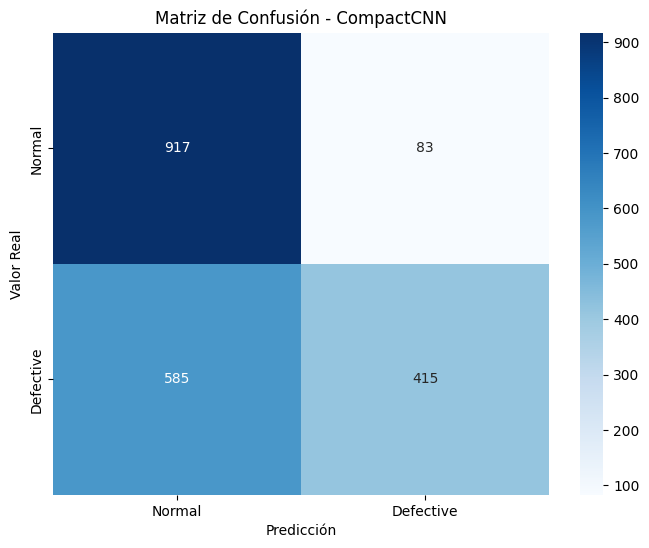

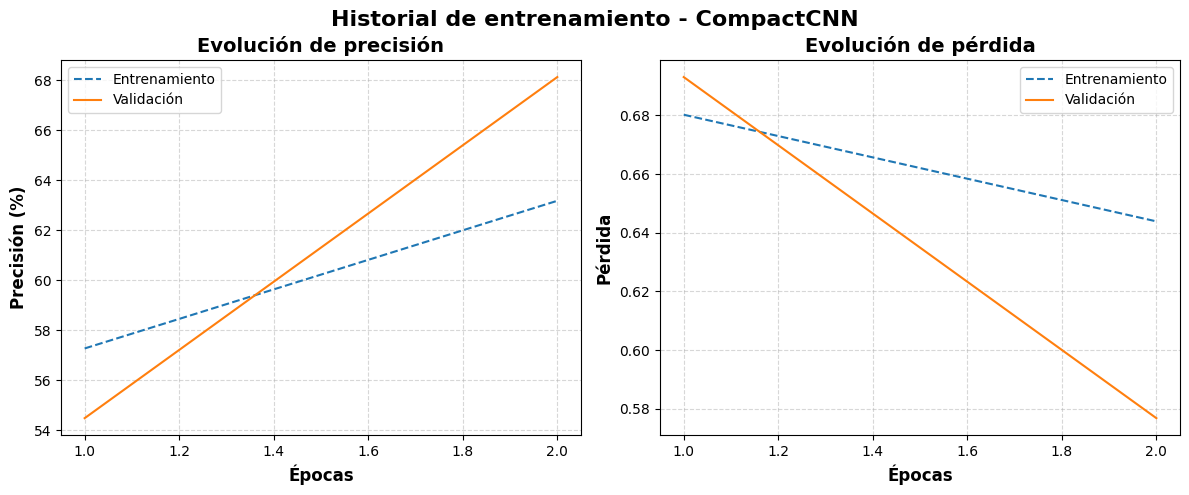


Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       0.61      0.92      0.73      1000
   Defective       0.83      0.41      0.55      1000

    accuracy                           0.67      2000
   macro avg       0.72      0.67      0.64      2000
weighted avg       0.72      0.67      0.64      2000

Entrenador configurado - Dispositivo: cpu

ENTRENANDO ModifiedResNet
Época 1/2 | Train Loss: 0.6802 Acc: 58.18% | Val Loss: 0.6130 Acc: 67.63% | Tiempo: 318.4s
Checkpoint guardado: ModifiedResNet_best_model.pth
Época 2/2 | Train Loss: 0.6248 Acc: 65.70% | Val Loss: 0.4761 Acc: 76.43% | Tiempo: 322.0s
Checkpoint guardado: ModifiedResNet_best_model.pth
Entrenamiento completado en 641.5s


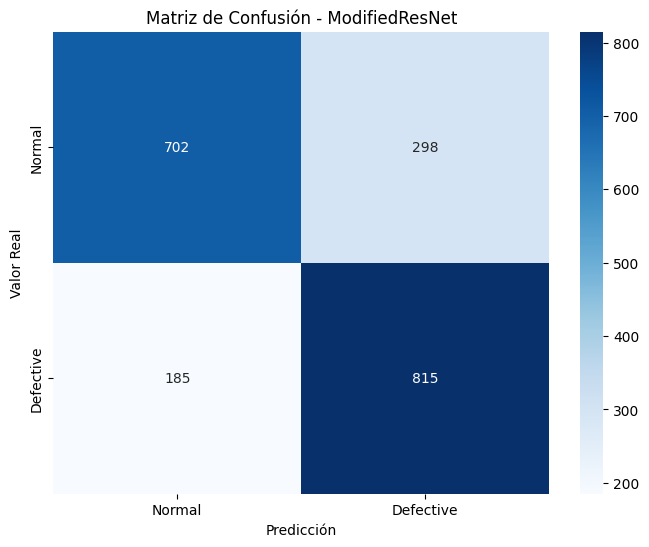

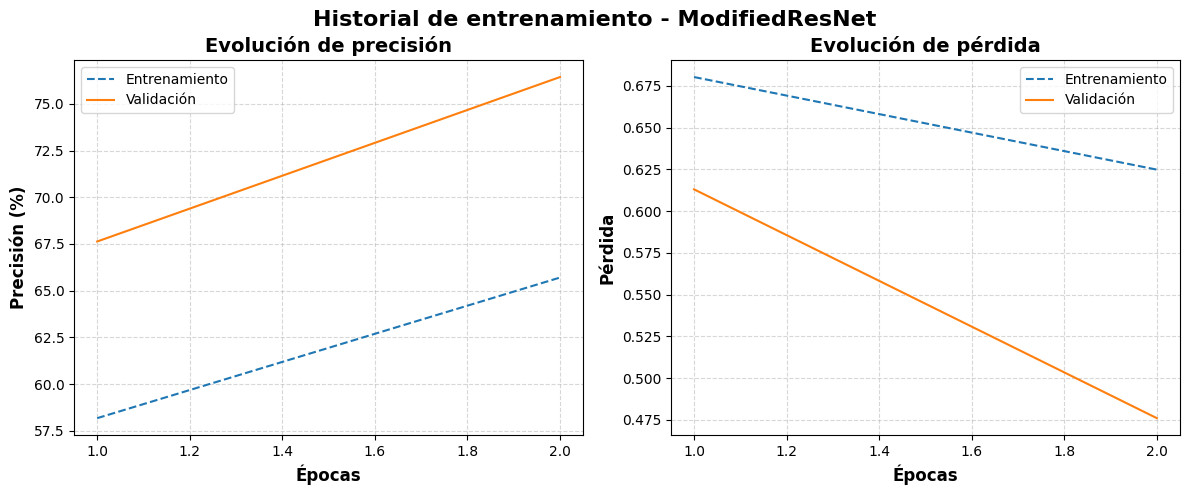


Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       0.79      0.70      0.74      1000
   Defective       0.73      0.81      0.77      1000

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000

Entrenador configurado - Dispositivo: cpu

ENTRENANDO ThermalNet
Época 1/2 | Train Loss: 0.6696 Acc: 58.46% | Val Loss: 0.5602 Acc: 66.73% | Tiempo: 373.8s
Checkpoint guardado: ThermalNet_best_model.pth
Época 2/2 | Train Loss: 0.5256 Acc: 74.20% | Val Loss: 0.4171 Acc: 82.25% | Tiempo: 375.8s
Checkpoint guardado: ThermalNet_best_model.pth
Entrenamiento completado en 749.7s


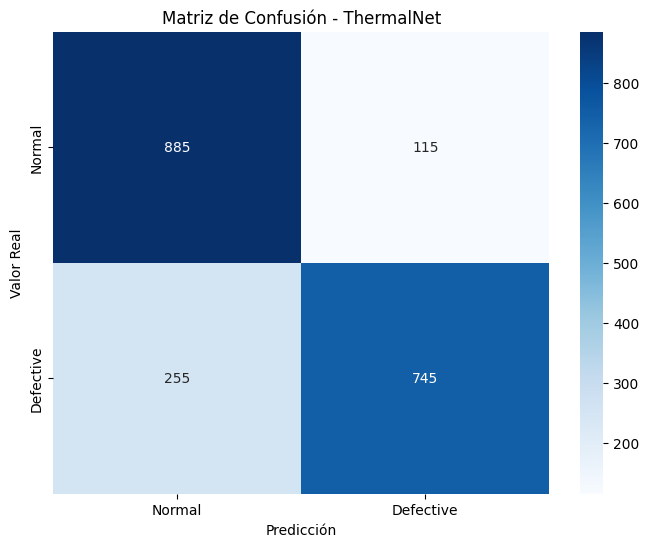

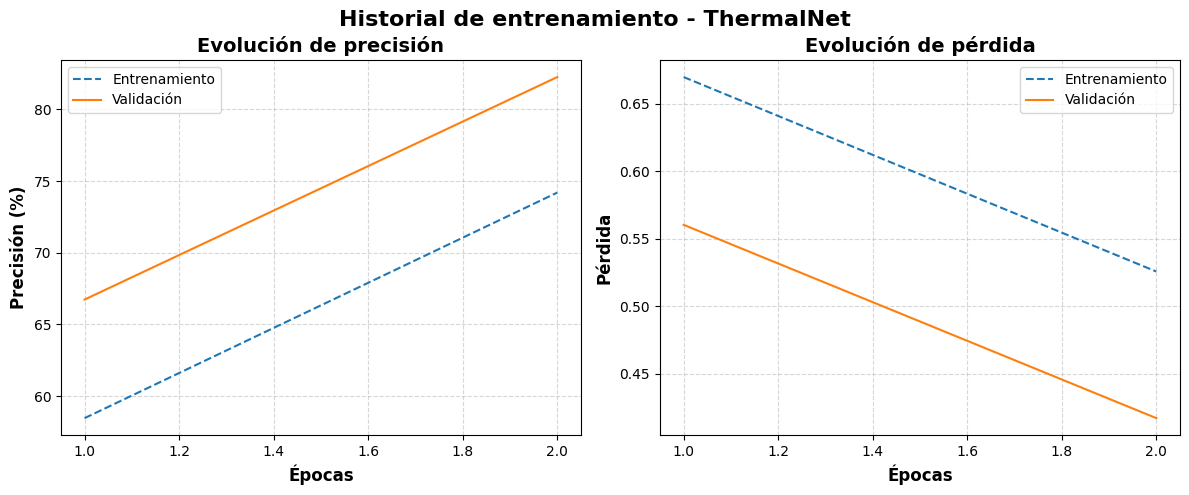


Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       0.78      0.89      0.83      1000
   Defective       0.87      0.74      0.80      1000

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000


RESULTADOS FINALES
CompactCNN: 66.60%
ModifiedResNet: 75.85%
ThermalNet: 81.50%


In [56]:
def main():
    """Función principal del proyecto"""
    Logger.section("SISTEMA DE DETECCIÓN DE ANOMALÍAS EN PANELES SOLARES")

    # Configurar semilla para reproducibilidad
    torch.manual_seed(Config.RANDOM_SEED)
    np.random.seed(Config.RANDOM_SEED)

    # Descargar y preparar datos
    dataset_path = download_and_extract_dataset()
    data_manager = SolarDataManager(dataset_path)

    # Dividir dataset
    train_df, val_df, test_df = data_manager.create_stratified_split()

    # Crear transformaciones
    train_transforms = DataTransforms.get_train_transforms()
    val_transforms = DataTransforms.get_val_transforms()

    # Crear datasets
    train_dataset = ThermalImageDataset(train_df, train_transforms)
    val_dataset = ThermalImageDataset(val_df, val_transforms)
    test_dataset = ThermalImageDataset(test_df, val_transforms)

    # Crear dataloaders
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

    # Modelos a entrenar
    models_to_train = [
        CompactCNN(num_classes=2),
        ModifiedResNet(num_classes=2),
        ThermalNet(num_classes=2)
    ]

    results = {}

    # Entrenar cada modelo
    for model in models_to_train:
        trainer = ModelTrainer(model, train_loader, val_loader, test_loader)
        train_history, val_history = trainer.train_model()
        test_accuracy = trainer.evaluate_on_test()

        results[model.__class__.__name__] = {
            'train_history': train_history,
            'val_history': val_history,
            'test_accuracy': test_accuracy
        }

    # Mostrar resumen final
    Logger.section("RESULTADOS FINALES")
    for model_name, metrics in results.items():
        Logger.log(f"{model_name}: {metrics['test_accuracy']:.2f}%", 'success')

if __name__ == "__main__":
    main()